# Лабораторная работа №6

*Кищенко Екатерина  
ПИН-212*

## Задание

>Провести классификацию найденного датасета, методами CatBoost

Импорт библиотек

In [70]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random as rand
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

Инициализация константы для random_state

In [23]:
# для повторяемости результатов
SEED = 100

Настройка графиков

In [24]:
# преднастройка графиков
plt.style.use("fivethirtyeight")
sns.set_style('whitegrid')

# вывод графиков в одном окне
%matplotlib inline

Установка catboost

In [4]:
!pip install catboost

  Obtaining dependency information for catboost from https://files.pythonhosted.org/packages/35/7e/35fa1a7cf6925ff438e849cca50c88b8d28e02d9c3486442f2f85b86184a/catboost-1.2.5-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for graphviz from https://files.pythonhosted.org/packages/00/be/d59db2d1d52697c6adc9eacaf50e8965b6345cc143f671e1ed068818d5cf/graphviz-0.20.3-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/101.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.1 MB 682.7 kB/s eta 0:02:29
   ---------------------------------------- 0.0/101.1 MB 660.6 kB/s eta 0:02:34
   ---------------------------------------- 0.0/101.1 MB 660.6 kB/s eta 0:02:34
   ---------------------------------------- 0.0/101.1 MB 281.8 kB/s eta 0:05:59
   ---------------------------------------- 0.1/101.1 MB 393.8 kB/s eta 0:04:17
   ---------------------------------------- 0.1/101.1 MB 476.3 kB/s eta 0:03:33
   ----------------------------------

Загрузка датасета

In [25]:
df = pd.read_csv('metal.csv', encoding='utf-8')
print(df.head(3))
print(df.dtypes)

               Spotify ID              Artist IDs Track Name  \
0  19vHgVS1aukRiQWhTqfKnE  1Ffb6ejR6Fe5IamqA5oRUF   DArkSide   
1  5BgnL6gHauuvxe4Ok6W1aC  1Ffb6ejR6Fe5IamqA5oRUF       LosT   
2  0M3adYbGtyRHACP86dey1H  1Ffb6ejR6Fe5IamqA5oRUF     Throne   

          Album Name        Artist Name(s) Release Date  Duration (ms)  \
0           DArkSide  Bring Me The Horizon   10/18/2023         164790   
1               LosT  Bring Me The Horizon     5/4/2023         205368   
2  That's The Spirit  Bring Me The Horizon    9/11/2015         191520   

   Popularity                                Added By              Added At  \
0          74  spotify:user:woth5clwe5p856iw52alp7uek  2023-10-25T13:10:28Z   
1          72  spotify:user:woth5clwe5p856iw52alp7uek  2023-10-25T13:10:28Z   
2          76  spotify:user:woth5clwe5p856iw52alp7uek  2023-10-25T13:10:28Z   

   ... Key  Loudness  Mode  Speechiness  Acousticness  Instrumentalness  \
0  ...   7    -3.018     1       0.1460      0.000352 

**Анализ датасета**  
Проверка на наличие отклонений важных характеристик числовых признаков: среднего арифметического, стандартного квадратичного отклонения, перцентилей, а также максимума и минимума

In [26]:
df.describe()

,Duration (ms),Popularity,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature
count,1.302000e+04,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000,13020.000000
mean,2.653518e+05,30.971813,0.352165,0.875350,5.240169,-6.460954,0.618894,0.093236,0.031006,0.346363,0.220432,0.269713,124.438288,3.875653
std,1.094013e+05,17.837263,0.137353,0.169119,3.524507,3.323075,0.485677,0.060338,0.134914,0.366784,0.163688,0.184397,29.406332,0.446000
min,7.373000e+03,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.026228e+05,19.000000,0.243000,0.856000,2.000000,-7.554000,0.000000,0.051100,0.000014,0.002800,0.101000,0.120000,102.170250,4.000000
50%,2.495795e+05,30.000000,0.348000,0.940000,5.000000,-5.701000,1.000000,0.078100,0.000107,0.159000,0.165000,0.234000,120.220500,4.000000
75%,3.088540e+05,43.000000,0.459000,0.975000,8.000000,-4.410000,1.000000,0.118000,0.001350,0.754000,0.310000,0.384000,142.350500,4.000000
max,1.511160e+06,88.000000,0.898000,1.000000,11.000000,0.431000,1.000000,0.882000,0.995000,0.999000,0.992000,0.972000,216.141000,5.000000


Уточнение показателей для категориальных данных

In [27]:
df.describe(include = [object, 'bool'])

,Spotify ID,Artist IDs,Track Name,Album Name,Artist Name(s),Release Date,Added By,Added At,Genres
count,13020,13020,13020,13020,13020,13020,13020,13020,12957
unique,11653,1321,10909,3529,1319,1949,1,386,1082
top,7Kvk7VM5yI9iXzJnmE2YuV,7L6u6TyhjuwubrcojPeNgf,Descending,Thulêan Mysteries,Burzum,1993,spotify:user:woth5clwe5p856iw52alp7uek,2023-10-25T16:20:46Z,"alternative metal,nu metal,rap metal,rock"
freq,3,201,6,29,201,153,13020,1002,285


Оценка категориальных признаков на наличие артефактов

In [28]:
# проходимся по столбцам датасета
for name, values in df.items():
  if values.dtype != np.float64:
    print(f"{name}: {df[name].unique()}")

Spotify ID: ['19vHgVS1aukRiQWhTqfKnE' '5BgnL6gHauuvxe4Ok6W1aC'
 '0M3adYbGtyRHACP86dey1H' ... '3trdEhvJEmaBEHKcr6RiWH'
 '47VSmPTydr0saGjbQGwCeg' '2302lUwfZ4S4dVyPOCDFnQ']
Artist IDs: ['1Ffb6ejR6Fe5IamqA5oRUF' '1Ffb6ejR6Fe5IamqA5oRUF,630wzNP2OL7fl4Xl0GnMWq'
 '6TIYQ3jFPwQSRmorSezPxX,1Ffb6ejR6Fe5IamqA5oRUF' ...
 '3Ri4H12KFyu98LMjSoij5V' '01ZtptlLUxoAbJDrS9fTqX'
 '0L5fC7Ogm2YwgqVCRcF1bT']
Track Name: ['DArkSide' 'LosT' 'Throne' ... 'If Today Was Your Last Day'
 'This Is Gonna Hurt' 'Sweet Dreams (Are Made Of This)']
Album Name: ['DArkSide' 'LosT' "That's The Spirit" ... 'Dark Horse'
 'This Is Gonna Hurt' 'Smells Like Children']
Artist Name(s): ['Bring Me The Horizon' 'Bring Me The Horizon,BABYMETAL'
 'mgk,Bring Me The Horizon' ... 'Bad Omens' 'Red Sun Rising' 'Volbeat']
Release Date: ['10/18/2023' '5/4/2023' '9/11/2015' ... '8/28/2008' '10/28/2008'
 '5/3/2011']
Duration (ms): [164790 205368 191520 ... 254805 182506 236293]
Popularity: [74 72 76 70 78 75 73 71 67 69 66 68 65 64 63 62 60 61 5

Проверка статистики по количеству мод

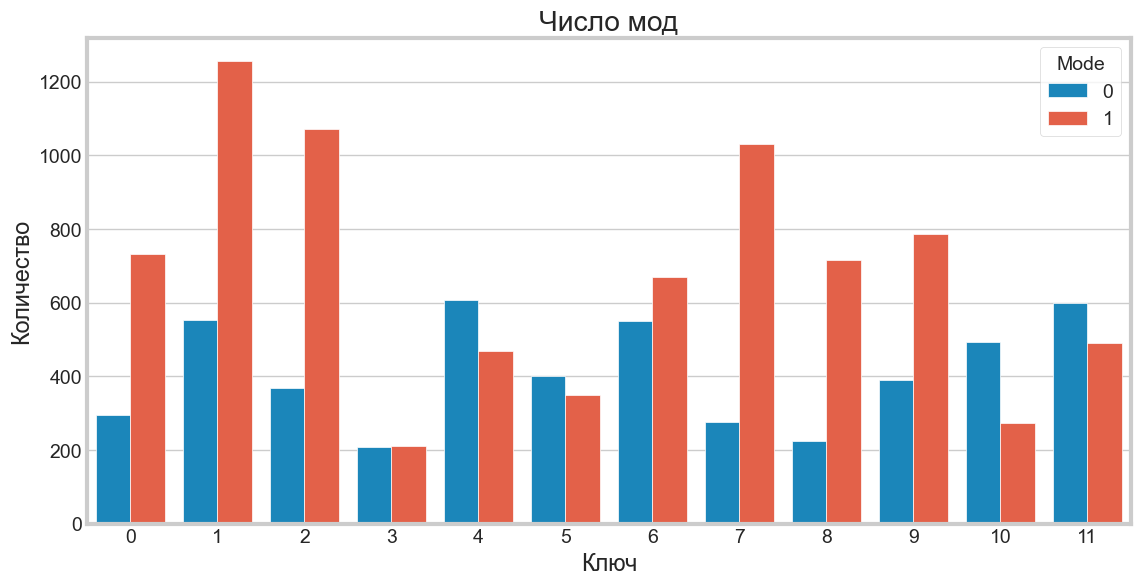

In [29]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(x="Key", hue="Mode", data=df)
ax.set(title='Число мод', xlabel='Ключ', ylabel='Количество')
plt.show()

Проверка статистики по покупке саперных наборов

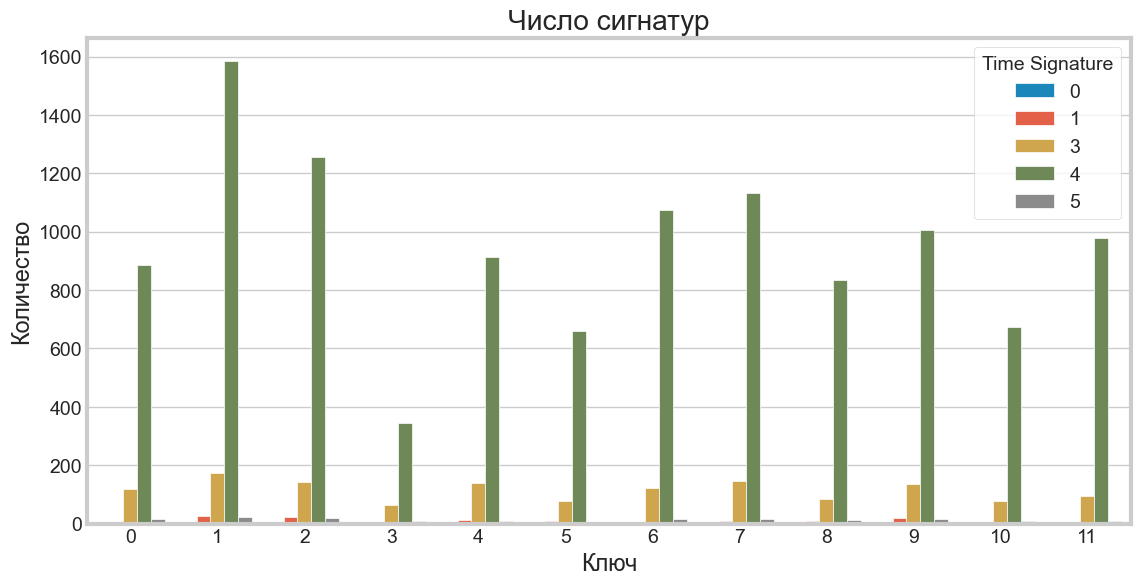

In [30]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(x="Key", hue="Time Signature", data=df)
ax.set(title='Число сигнатур', xlabel='Ключ', ylabel='Количество')
plt.show()

Проверка распределения уровня танцевальности и энергичности

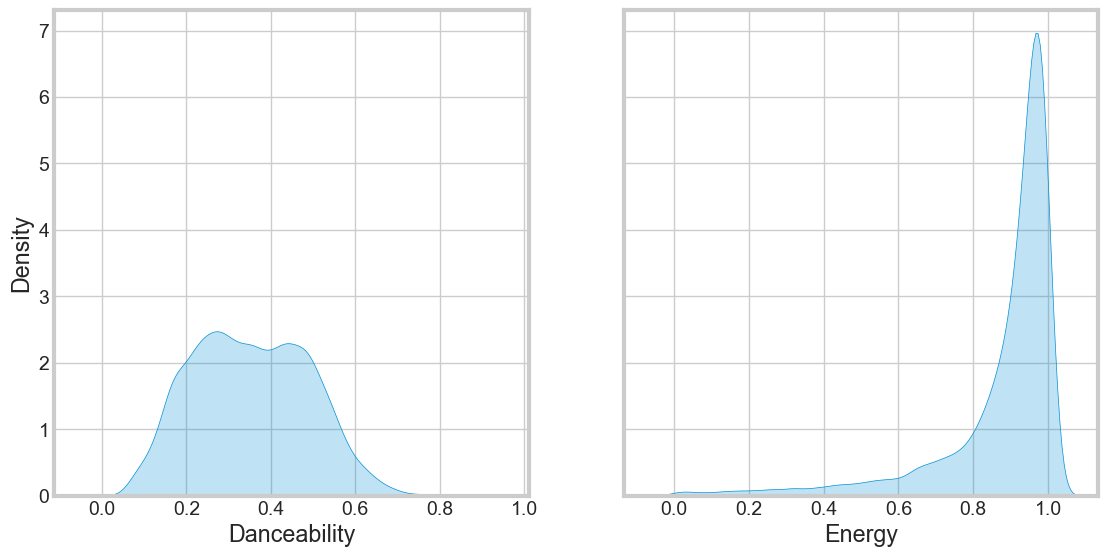

In [31]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(12,6))
sns.kdeplot(df['Danceability'], fill=True, ax=ax1);
sns.kdeplot(df['Energy'], fill=True, ax=ax2);

Проверка распределения популярности

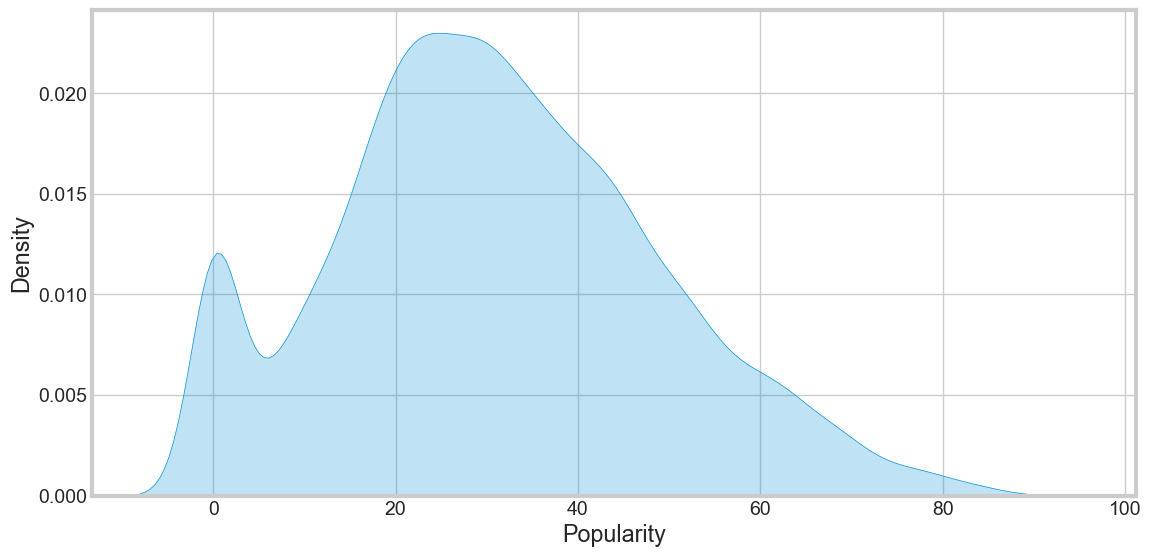

In [32]:
fig, (ax1) = plt.subplots(ncols=1, sharey=True, figsize=(12,6))
sns.kdeplot(df['Popularity'], fill=True, ax=ax1);

Проверка распределения времени

<Axes: xlabel='Duration (ms)', ylabel='Density'>

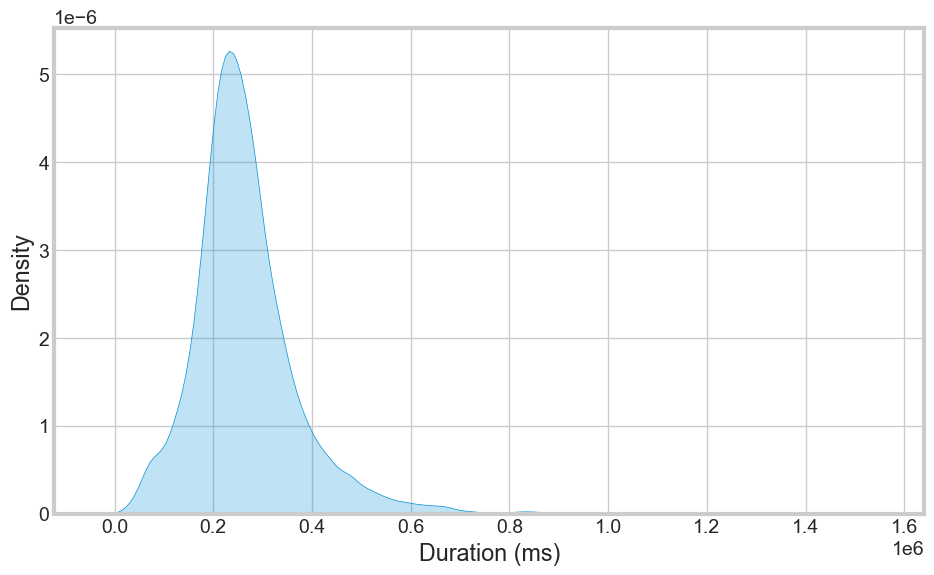

In [33]:
plt.figure(figsize=(10,6))
sns.kdeplot(df['Duration (ms)'], fill=True)

**Проверка сбалансированности**

Построение гистограммы распределения целевого признака «Added By» для проверки сбалансированности

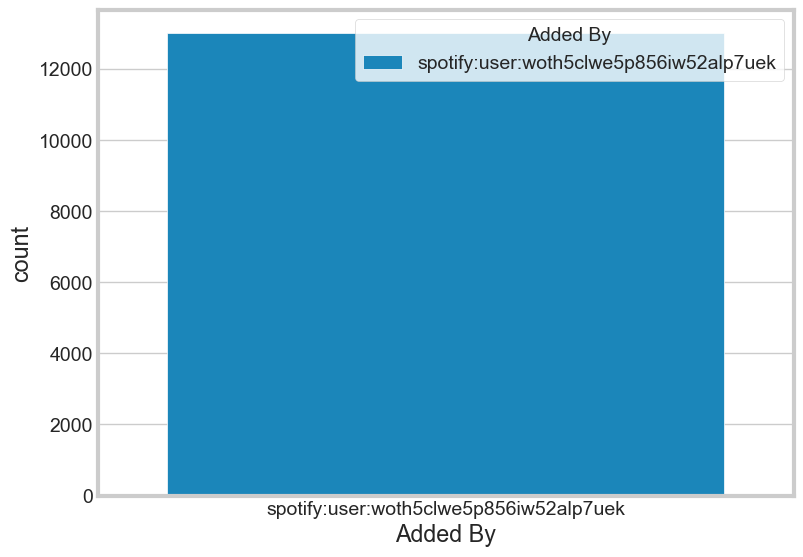

In [34]:
plt.figure(figsize=(8, 6))
sns.countplot(
    data=df,
    x='Added By',
    hue='Added By'
)
plt.show()

**Обобщение датасета**

Создание обобщенного датасета

In [35]:
# новый датасет для проверки корелляции
grouped_df = df

# создаем новые столбцы для сумм популярности, длительности и танцевальности
grouped_df['Popularity'] = df[
    [col for col in df.columns if col.startswith('Popularity')]].sum(axis=1)
grouped_df['Duration (ms)'] = df[
    [col for col in df.columns if col.startswith('Duration (ms)')]].sum(axis=1)
grouped_df['Danceability'] = df[
    [col for col in df.columns if col.startswith('Danceability')]].sum(axis=1)

# удаляем старые столбцы
grouped_df = grouped_df.drop([col for col in df.columns if col.startswith((
    'Popularity', 'Duration (ms)', 'Danceability'))], axis=1)

# выводим получившуюся структуру
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13020 entries, 0 to 13019
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Spotify ID        13020 non-null  object 
 1   Artist IDs        13020 non-null  object 
 2   Track Name        13020 non-null  object 
 3   Album Name        13020 non-null  object 
 4   Artist Name(s)    13020 non-null  object 
 5   Release Date      13020 non-null  object 
 6   Added By          13020 non-null  object 
 7   Added At          13020 non-null  object 
 8   Genres            12957 non-null  object 
 9   Energy            13020 non-null  float64
 10  Key               13020 non-null  int64  
 11  Loudness          13020 non-null  float64
 12  Mode              13020 non-null  int64  
 13  Speechiness       13020 non-null  float64
 14  Acousticness      13020 non-null  float64
 15  Instrumentalness  13020 non-null  float64
 16  Liveness          13020 non-null  float6

Прямое преобразование категориальных признаков в числовые

In [36]:
# переведем категориальный признак «Added By» в числовой
Added_new = {
    'spotify:user:woth5clwe5p856iw52alp7uek' : 1
}

grouped_df['Added By'] = grouped_df['Added By'].map(Added_new).astype('uint8')

Вывод случайной записи

In [43]:
sample_index = rand.randint(0, len(grouped_df['Added By']) - 1)
print(grouped_df.iloc[sample_index])

Spotify ID                                     6zg5zLWJoThyPUBT31DTp5
Artist IDs                                     6kEQuZgj4hm2mE2ZfZ6mcD
Track Name                                             Summoning Fear
Album Name                                                 Gesundrian
Artist Name(s)                                             Diocletian
Release Date                                                5/23/2014
Added By                                                            1
Added At                                         2023-12-27T13:01:48Z
Genres              black death,nz metal,voidgaze,voidgrind,war metal
Energy                                                          0.908
Key                                                                 6
Loudness                                                       -8.592
Mode                                                                0
Speechiness                                                     0.113
Acousticness        

**Проверка на наличие незначащих признаков**

Проверка корреляции признаков

C:\Users\Екатерина\AppData\Local\Temp\ipykernel_16364\1673895220.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(grouped_df.corr(), annot=True, fmt=".1f");


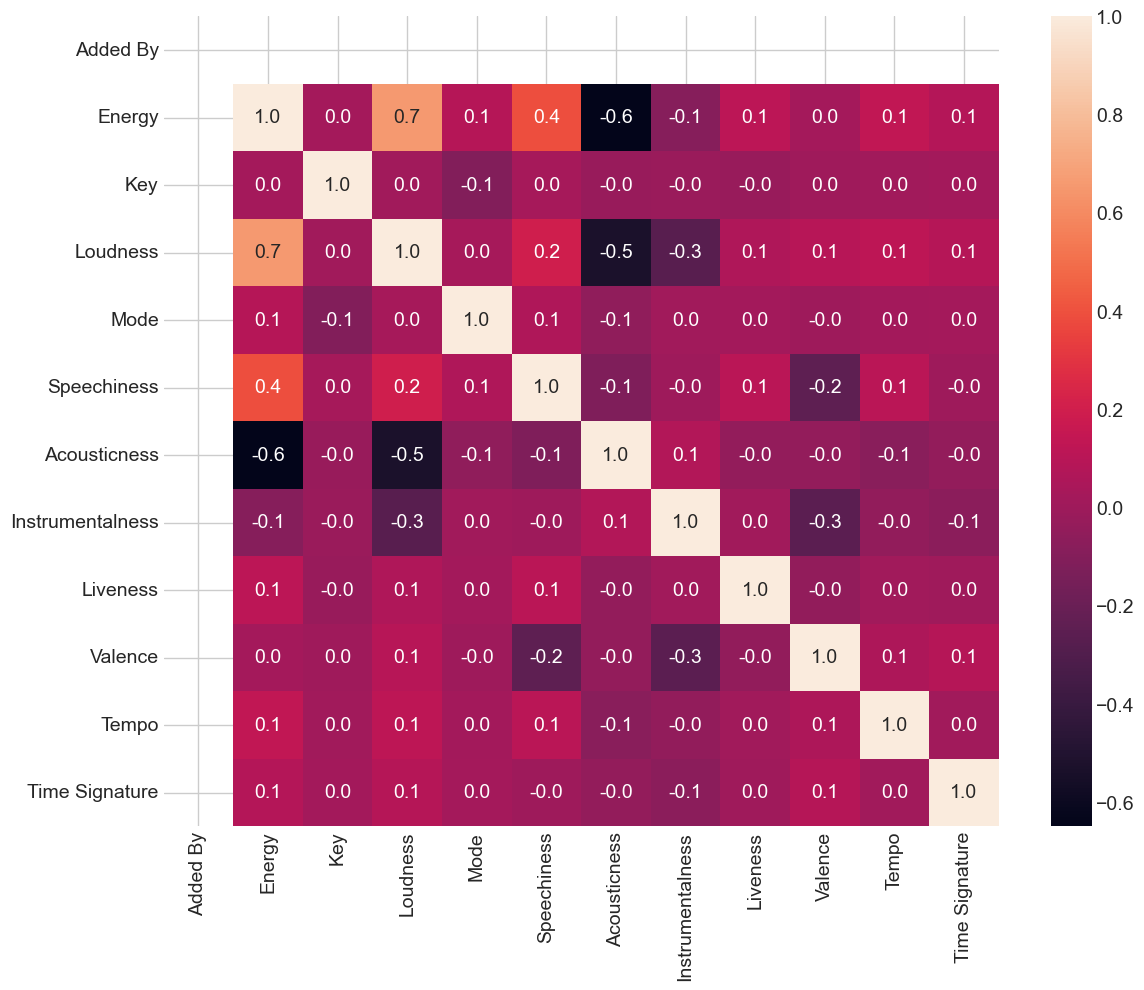

In [44]:
# размер графика
plt.figure(figsize=(12, 10))

# таблица корреляции
sns.heatmap(grouped_df.corr(), annot=True, fmt=".1f");

Удаляем незначащий признак Key

In [45]:
# удаляем ненужные столбцы
grouped_df = grouped_df.drop(['Key'], axis=1)

# проверяем
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13020 entries, 0 to 13019
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Spotify ID        13020 non-null  object 
 1   Artist IDs        13020 non-null  object 
 2   Track Name        13020 non-null  object 
 3   Album Name        13020 non-null  object 
 4   Artist Name(s)    13020 non-null  object 
 5   Release Date      13020 non-null  object 
 6   Added By          13020 non-null  uint8  
 7   Added At          13020 non-null  object 
 8   Genres            12957 non-null  object 
 9   Energy            13020 non-null  float64
 10  Loudness          13020 non-null  float64
 11  Mode              13020 non-null  int64  
 12  Speechiness       13020 non-null  float64
 13  Acousticness      13020 non-null  float64
 14  Instrumentalness  13020 non-null  float64
 15  Liveness          13020 non-null  float64
 16  Valence           13020 non-null  float6

**Подготовка данных**  
Заполнение отсутствующих значений

Проверка на наличие пропусков

In [47]:
# отдельно считаем количество пустых записей в столбцах
skips_num = grouped_df.isna().sum()

print(f"Пропуски по столбцам:\n{skips_num}\n")

# выводим сумму по столбцам
print(f"Всего пропусков: {skips_num.sum()}")

Пропуски по столбцам:
Spotify ID           0
Artist IDs           0
Track Name           0
Album Name           0
Artist Name(s)       0
Release Date         0
Added By             0
Added At             0
Genres              63
Energy               0
Loudness             0
Mode                 0
Speechiness          0
Acousticness         0
Instrumentalness     0
Liveness             0
Valence              0
Tempo                0
Time Signature       0
dtype: int64

Всего пропусков: 63


Удаление строк с пропущенными значениями

In [57]:
df.dropna(inplace=True)

**Выбор обучающего и тестового наборов**

In [73]:
# Кодирование категориальных признаков
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

X = df.drop('Mode', axis=1)
Y = df['Mode']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

**Масштабирование признаков**

In [76]:
scaler = StandardScaler()
numeric_features = df.select_dtypes(include=['int32', 'int64', 'float32', 'float64']).columns
df[numeric_features] = scaler.fit_transform(df[numeric_features])